# Experiment Tracking with MLFlow (Local)

In this demo we will see how to use MLFlow for tracking experiments, using a toy data set. In the attached lab (below), you will download a larger dataset and attempt to train the best model that you can.

We should first install mlflow, and add it to the requirements.txt file if not done already.

`pip install mlflow` or `python3 -m pip install mlflow`.

You may also need to `pip install setuptools`.

From here, make sure to save this notebook in a specific folder, and ensure you run all command line commands from the same folder.

In [1]:
import mlflow
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_wine
from sklearn.metrics import accuracy_score

In [2]:
# Add this to your notebook
import mlflow
print("Current tracking URI:", mlflow.get_tracking_uri())

# If needed, reset it explicitly
# mlflow.set_tracking_uri("sqlite:///mlflow.db")

# For this lab 4
mlflow.set_tracking_uri('https://mlflow-server1-759416646959.us-west2.run.app')

Current tracking URI: file:///Users/danielmendoza/Documents/Spring_Mod_2/MLOps/mlops_labs/notebooks/mlruns


After loading the libraries, we can first check the mlflow version you have. And, just for fun, let's look at the mlflow UI by running `mlflow ui`. After this, we should do two things:
- set the tracking uri
- create or set the experiment

Setting the tracking uri tells mlflow where to save the results of our experiments. We will first save these locally in a sqlite instance. In a future lab we will set up mlflow to run in GCP.

If you've already created an experiment previously that you'd like to use, you can tell mlflow by setting the experiment. You can also use `set_experiment` even if the experiment has not yet been created - mlflow will first check if the experiment exists, and if not, it will create it for you. 

In [3]:
mlflow.__version__

'2.15.1'

Running the below code will create a sqlite database and an mlruns folder in the current directory.

In [4]:
# mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment('demo-experiment')

<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1744950674384, experiment_id='1', last_update_time=1744950674384, lifecycle_stage='active', name='demo-experiment', tags={}>

In [5]:
# .

In [6]:
import mlflow
print("Current tracking URI:", mlflow.get_tracking_uri())

# If needed, set it explicitly
# mlflow.set_tracking_uri("sqlite:///mlflow.db")  # Adjust the path as needed

Current tracking URI: https://mlflow-server1-759416646959.us-west2.run.app


In [7]:
import mlflow

# Start a new run in the default experiment
with mlflow.start_run():
    # Log some basic parameters and metrics
    mlflow.log_param("param1", "test")
    mlflow.log_metric("metric1", 0.95)
    
    # Print the active run ID to confirm it's working
    print("Active run ID:", mlflow.active_run().info.run_id)

2025/04/17 21:32:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run sincere-foal-898 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1/runs/1899a4db77474049936f0eb5578596af.
2025/04/17 21:32:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1.


Active run ID: 1899a4db77474049936f0eb5578596af


In [8]:
import mlflow

# List all runs in the default experiment
experiment_id = "0"  # Default experiment has ID 0
runs = mlflow.search_runs(experiment_ids=[experiment_id])
print(f"Found {len(runs)} runs in the default experiment")
print(runs)

Found 1 runs in the default experiment
                             run_id experiment_id  status  \
0  2237e02f372e4d3ca0cf3772dbbbab9d             0  FAILED   

                                        artifact_uri  \
0  gs://mlflow-artifacts-dm/mlruns/0/2237e02f372e...   

                        start_time                         end_time  \
0 2025-04-18 04:25:37.513000+00:00 2025-04-18 04:25:40.451000+00:00   

   metrics.rmse params.n_estimators tags.mlflow.user tags.mlflow.runName  \
0     57.921405                 100    danielmendoza     secretive-fly-2   

  tags.mlflow.source.type             tags.mlflow.source.git.commit  \
0                   LOCAL  0c6b3e7970bc370a2f77e217a7173497c71862a8   

  tags.mlflow.source.name  
0                train.py  


In [9]:
import os
print("mlflow.db exists:", os.path.exists("mlflow.db"))
print("Current working directory:", os.getcwd())

mlflow.db exists: True
Current working directory: /Users/danielmendoza/Documents/Spring_Mod_2/MLOps/mlops_labs/notebooks


From here, we can load the wine data from sklearn and take a look at it. Then let's play around with some models, without using mlflow for now, to get a sense of why mlflow might come in handy.

In [10]:
wine = load_wine()
df_wine = pd.DataFrame(data=wine.
data, columns=wine.feature_names)
df_wine.head(3)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0


In [11]:
y = wine.target
X = df_wine
dt = DecisionTreeClassifier(max_depth=4)
dt.fit(X, y)

DecisionTreeClassifier(max_depth=4)

In [12]:
accuracy_score(y, dt.predict(df_wine))

0.9887640449438202

## Train a Model Using MLFLow

In this section, let's train a simple decision tree model, where we will now adjust the maximum depth (`max_depth`) of the tree, and save the results of each run of the experiment using mlflow. To do so, we need to tell mlflow to start recording. We do this with `start_run`. 

The things we might want to record in this simple case are:
- the value of `max_depth`
- the corresponding accuracy of the model

We can also tag each run to make it easier to identify them later.

After running the below code, be sure to check the mlflow UI by running the following in the terminal from the same directory as where you saved this notebook:

`mlflow ui` note that just running this you will not see any of your experiments. You must specify the uri (the place where all of your results are being stored)

`mlflow ui --backend-store-uri sqlite:///mlflow.db`

In [13]:
with mlflow.start_run():
    # log parameters and log metrics
    # parameters: hyperparameters
    # metrics: model performance metrics

    mlflow.set_tags({"Model":"decision-tree", "Train Data": "all-data"})

    tree_depth = 5
    dt = DecisionTreeClassifier(max_depth=tree_depth)
    dt.fit(X, y)
    acc = accuracy_score(y, dt.predict(df_wine))

    mlflow.log_param("max_depth", tree_depth)
    mlflow.log_metric("accuracy", acc)

mlflow.end_run()

2025/04/17 21:32:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run clean-wolf-56 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1/runs/c47d1c37518a4a17a3a02f2bb3b456f7.
2025/04/17 21:32:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1.


Let's do it again, but this time we'll use a random forest, which has some other hyperparameters we can tune, which makes keeping track of things a little more complex without a tool like mlflow.

In [14]:
from sklearn.ensemble import RandomForestClassifier

with mlflow.start_run():
    mlflow.set_tags({"Model":"random-forest", "Train Data": "all-data"})

    ntree = 1000
    mtry = 4

    mlflow.log_params({'n_estimators':ntree, 'max_features':mtry})

    rf = RandomForestClassifier(n_estimators = ntree, max_features = mtry, oob_score = True)
    rf.fit(X,y)
    acc = rf.oob_score_
    #acc = accuracy_score(y, rf.predict(X))
    mlflow.log_metric('accuracy', acc)

mlflow.end_run()

2025/04/17 21:32:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run fun-rook-910 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1/runs/2bc8556c19404a21997ac0db8af58afa.
2025/04/17 21:32:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1.


Typically, in a real-world scenario, you wouldn't change your parameter values manually and re-run your code, you would either use a loop to loop through different parameter values, or you'd use a built-in method for doing cross-validation, of which there are a few. First, let's use a simple loop to run the experiment multiple times, and save the results of each run.

In [15]:
ntrees = [20,40,60,80,100]
mtrys = [3,4,5]
for i in ntrees:
    for j in mtrys:
        with mlflow.start_run():
            mlflow.set_tags({"Model":"random-forest", "Train Data": "all-data"})

            mlflow.log_params({'n_estimators':i, 'max_features':j})

            rf = RandomForestClassifier(n_estimators = i, max_features = j, oob_score = True)
            rf.fit(X,y)
            acc = rf.oob_score_
            #acc = accuracy_score(y, rf.predict(X))
            mlflow.log_metric('accuracy', acc)
        mlflow.end_run()

2025/04/17 21:32:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run colorful-ox-49 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1/runs/4e35da61528847e9b8b44afb839e1a3a.
2025/04/17 21:32:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1.
2025/04/17 21:32:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run bittersweet-toad-16 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1/runs/1dcd0e8d492c4ae5a33df918a21bed9b.
2025/04/17 21:32:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1.
2025/04/17 21:32:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run puzzled-ram-531 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1/runs/12a4a821e2fe421ebf8352cfae7e2eb9.
2025/04/17 21:32:51 INFO mlflow.tracking._tracking_service.cl

In [16]:
# .

## Training a Model with mlflow and hyperopt

One way of tuning your model is to use the `hyperopt` library. `hyperopt` is a library that does hyperparameter tuning, and does so in a way that makes it easy for mlflow to keep track of the results. 

First, install the libraries you don't have, and then load them below. We do not use `hyperopt` much in the class, so if you don't want to add it to your requirements.txt file, you don't have to.

For this exercise, we'll split the data into training and validation, and then we'll train decision trees and random forests and use `hyperopt` to do the hyperparameter tuning and find the best model for us.

In [17]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

From the above we will use `cross_val_score` for our metric, `fmin` is used by `hyperopt` to do the tuning, `tpe` (Tree of Parzen Estimators) is the algorithm used to search the hyperparameter space,  `hp` has methods we need to use for defining our search space, `STATUS_OK` is a status message that each run completed, and `Trials` keeps track of each run.

In [18]:
def objective(params):
    with mlflow.start_run():
        classifier_type = params['type']
        del params['type']
        if classifier_type == 'dt':
            clf = DecisionTreeClassifier(**params)
        elif classifier_type == 'rf':
            clf = RandomForestClassifier(**params)        
        else:
            return 0
        acc = cross_val_score(clf, X, y).mean()

        mlflow.set_tag("Model", classifier_type)
        mlflow.log_params(params)
        mlflow.log_metric("accuracy", acc)
        mlflow.end_run()
        return {'loss': -acc, 'status': STATUS_OK}

search_space = hp.choice('classifier_type', [
    {
        'type': 'dt',
        'criterion': hp.choice('dtree_criterion', ['gini', 'entropy']),
        'max_depth': hp.choice('dtree_max_depth', [None, hp.randint('dtree_max_depth_int', 1,10)]),
        'min_samples_split': hp.randint('dtree_min_samples_split', 2,10)
    },
    {
        'type': 'rf',
        'n_estimators': hp.randint('rf_n_estimators', 20, 500),
        'max_features': hp.randint('rf_max_features', 2,9),
        'criterion': hp.choice('criterion', ['gini', 'entropy'])
    },
])

algo = tpe.suggest
trials = Trials()

In [19]:
best_result = fmin(
        fn=objective, 
        space=search_space,
        algo=algo,
        max_evals=32,
        trials=trials)

  0%|          | 0/32 [00:00<?, ?trial/s, best loss=?]

2025/04/17 21:32:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run abrasive-gull-63 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1/runs/5c2009dd7a294697baeabb225dc1af84.

2025/04/17 21:32:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1.



  3%|▎         | 1/32 [00:00<00:26,  1.19trial/s, best loss: -0.9665079365079364]

2025/04/17 21:32:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run enchanting-snail-696 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1/runs/98ceb35810334fe1810c22bf9e5ae4b1.

2025/04/17 21:32:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1.



  6%|▋         | 2/32 [00:01<00:17,  1.74trial/s, best loss: -0.9665079365079364]

2025/04/17 21:32:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run enthused-deer-827 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1/runs/51804933ad594cbe953d6a6e78f84594.

2025/04/17 21:32:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1.



  9%|▉         | 3/32 [00:02<00:20,  1.45trial/s, best loss: -0.9665079365079364]

2025/04/17 21:32:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run orderly-wren-1000 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1/runs/3cc19b90c5ee4e68ae4267b31025b622.

2025/04/17 21:32:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1.



 12%|█▎        | 4/32 [00:02<00:15,  1.84trial/s, best loss: -0.9665079365079364]

2025/04/17 21:32:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run debonair-loon-192 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1/runs/bb9bb285a8a34b6ea9d7b2074e7504ca.

2025/04/17 21:32:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1.



 16%|█▌        | 5/32 [00:03<00:20,  1.32trial/s, best loss: -0.972063492063492] 

2025/04/17 21:33:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run youthful-asp-650 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1/runs/77734eeef36340bd8cf1476aa43aaa2b.

2025/04/17 21:33:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1.



 19%|█▉        | 6/32 [00:05<00:26,  1.02s/trial, best loss: -0.972063492063492]

2025/04/17 21:33:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run grandiose-hen-860 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1/runs/ea71205dfe2e41d38b2c5c19df4a4604.

2025/04/17 21:33:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1.



 22%|██▏       | 7/32 [00:05<00:19,  1.28trial/s, best loss: -0.972063492063492]

2025/04/17 21:33:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run awesome-shrimp-880 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1/runs/3da59b9ac2e34c6db5fa0a8a2aea2287.

2025/04/17 21:33:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1.



 25%|██▌       | 8/32 [00:05<00:15,  1.53trial/s, best loss: -0.972063492063492]

2025/04/17 21:33:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run legendary-snail-940 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1/runs/5ec42ad365124c8189c2ab737227dee5.

2025/04/17 21:33:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1.



 28%|██▊       | 9/32 [00:06<00:13,  1.70trial/s, best loss: -0.972063492063492]

2025/04/17 21:33:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run trusting-steed-292 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1/runs/527a5e6d713b4aa58dc3c2c4850952c3.

2025/04/17 21:33:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1.



 31%|███▏      | 10/32 [00:08<00:21,  1.02trial/s, best loss: -0.972063492063492]

2025/04/17 21:33:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run nervous-elk-908 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1/runs/03c849814060450383791ab989c60095.

2025/04/17 21:33:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1.



 34%|███▍      | 11/32 [00:08<00:16,  1.29trial/s, best loss: -0.972063492063492]

2025/04/17 21:33:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run intrigued-mouse-749 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1/runs/6b780b449cb14bd5a3dad9a96a784a96.

2025/04/17 21:33:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1.



 38%|███▊      | 12/32 [00:08<00:13,  1.48trial/s, best loss: -0.972063492063492]

2025/04/17 21:33:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run bright-goat-622 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1/runs/47a881f12e584b2c9e2ca9aca8821091.

2025/04/17 21:33:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1.



 41%|████      | 13/32 [00:09<00:10,  1.78trial/s, best loss: -0.972063492063492]

2025/04/17 21:33:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run vaunted-kite-725 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1/runs/0be9f35a2dc54940a5f66699854135c4.

2025/04/17 21:33:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1.



 44%|████▍     | 14/32 [00:09<00:08,  2.07trial/s, best loss: -0.972063492063492]

2025/04/17 21:33:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run dashing-auk-656 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1/runs/c1630a10b15041e49d187b6a154c7aed.

2025/04/17 21:33:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1.



 47%|████▋     | 15/32 [00:10<00:12,  1.34trial/s, best loss: -0.972063492063492]

2025/04/17 21:33:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run clumsy-dog-573 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1/runs/2623ef9be40f4a04ac0f9bbf04e501e5.

2025/04/17 21:33:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1.



 50%|█████     | 16/32 [00:13<00:22,  1.42s/trial, best loss: -0.972063492063492]

2025/04/17 21:33:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run mercurial-foal-596 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1/runs/c9ac5510acd6451db42e3bc604405a63.

2025/04/17 21:33:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1.



 53%|█████▎    | 17/32 [00:15<00:23,  1.53s/trial, best loss: -0.9776190476190475]

2025/04/17 21:33:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run abundant-shrew-192 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1/runs/c0cefcc0bb2a437baad5ca5139ac3c66.

2025/04/17 21:33:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1.



 56%|█████▋    | 18/32 [00:16<00:20,  1.45s/trial, best loss: -0.9776190476190475]

2025/04/17 21:33:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run wistful-fly-942 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1/runs/7a617797408e42f6ac5a41d8eb4430d0.

2025/04/17 21:33:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1.



 59%|█████▉    | 19/32 [00:17<00:16,  1.25s/trial, best loss: -0.9776190476190475]

2025/04/17 21:33:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run sedate-colt-766 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1/runs/358ad8f702d3497081e135c972f3f5f1.

2025/04/17 21:33:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1.



 62%|██████▎   | 20/32 [00:19<00:16,  1.35s/trial, best loss: -0.9776190476190475]

2025/04/17 21:33:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run shivering-hare-109 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1/runs/56a7ae93b60e47388cc38e1c32d81e95.

2025/04/17 21:33:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1.



 66%|██████▌   | 21/32 [00:19<00:12,  1.09s/trial, best loss: -0.9776190476190475]

2025/04/17 21:33:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run clumsy-slug-70 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1/runs/c0c284be623b46e4bb729fd13e30fbc5.

2025/04/17 21:33:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1.



 69%|██████▉   | 22/32 [00:20<00:09,  1.04trial/s, best loss: -0.9776190476190475]

2025/04/17 21:33:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run ambitious-dog-443 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1/runs/6d6a42e3f33644d8be289e0250adbc12.

2025/04/17 21:33:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1.



 72%|███████▏  | 23/32 [00:21<00:08,  1.07trial/s, best loss: -0.9776190476190475]

2025/04/17 21:33:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run big-carp-13 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1/runs/eba0bede4920439fb539e6dcb7fc47d6.

2025/04/17 21:33:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1.



 75%|███████▌  | 24/32 [00:23<00:09,  1.23s/trial, best loss: -0.9776190476190475]

2025/04/17 21:33:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run luxuriant-gnat-717 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1/runs/09f877534b344fa5884a6e36f40fdd7a.

2025/04/17 21:33:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1.



 78%|███████▊  | 25/32 [00:23<00:07,  1.05s/trial, best loss: -0.9776190476190475]

2025/04/17 21:33:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run funny-bass-430 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1/runs/dee283c6377946739bc7c660c7861a74.

2025/04/17 21:33:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1.



 81%|████████▏ | 26/32 [00:25<00:07,  1.24s/trial, best loss: -0.9776190476190475]

2025/04/17 21:33:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run victorious-cat-623 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1/runs/de765e9649894670bffb029973ad17f9.

2025/04/17 21:33:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1.



 84%|████████▍ | 27/32 [00:27<00:07,  1.42s/trial, best loss: -0.9776190476190475]

2025/04/17 21:33:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run tasteful-penguin-800 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1/runs/f66b7841b20841d3a61fa2c4cbbed007.

2025/04/17 21:33:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1.



 88%|████████▊ | 28/32 [00:27<00:04,  1.15s/trial, best loss: -0.9776190476190475]

2025/04/17 21:33:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run bouncy-calf-61 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1/runs/1d810e3bb0b04182a3ddd618ccb90389.

2025/04/17 21:33:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1.



 91%|█████████ | 29/32 [00:28<00:03,  1.08s/trial, best loss: -0.9776190476190475]

2025/04/17 21:33:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run calm-yak-951 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1/runs/27a0999fc4b54e82a54dcb9016780d3b.

2025/04/17 21:33:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1.



 94%|█████████▍| 30/32 [00:29<00:01,  1.11trial/s, best loss: -0.9833333333333332]

2025/04/17 21:33:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run redolent-bee-338 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1/runs/d866c0e6201047749c2dd17ac41eaa04.

2025/04/17 21:33:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1.



 97%|█████████▋| 31/32 [00:30<00:01,  1.09s/trial, best loss: -0.9833333333333332]

2025/04/17 21:33:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run overjoyed-robin-723 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1/runs/773a4aacda5e4e2480c56bd1bfcdccc7.

2025/04/17 21:33:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1.



100%|██████████| 32/32 [00:31<00:00,  1.01trial/s, best loss: -0.9833333333333332]


In [20]:
best_result

{'classifier_type': 1,
 'criterion': 0,
 'rf_max_features': 2,
 'rf_n_estimators': 57}

### Using Autologging

Rather than manually logging parameters and metrics, mlflow has an autolog feature, which is compatible with a subset of python libraries, such as sklearn. Autologging makes it easy to log all of the important stuff, without having to manually write lines of code to log the parameters. However, sometimes you will want to have finer control over what gets logged, and should instead skip autologging.

In [21]:
with mlflow.start_run():
    mlflow.sklearn.autolog()
    tree_depth = 5
    dt = DecisionTreeClassifier(max_depth=tree_depth)
    dt.fit(X_train, y_train)
    mlflow.sklearn.autolog(disable=True)
mlflow.end_run()

2025/04/17 21:33:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run bittersweet-roo-957 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1/runs/c5d18b3582e74b1380ada90dbf20273d.
2025/04/17 21:33:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1.


In [22]:
# Enable autologging at the beginning, before starting any runs
mlflow.sklearn.autolog()

# Then start your run and fit the model
with mlflow.start_run():
    tree_depth = 5
    dt = DecisionTreeClassifier(max_depth=tree_depth)
    dt.fit(X_train, y_train)
    
# Disable autologging after the run if needed
mlflow.sklearn.autolog(disable=True)

2025/04/17 21:33:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run sneaky-duck-134 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1/runs/8b018d2cfe3d4b39922875f02f4a0c81.
2025/04/17 21:33:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1.


# Artifact Tracking and Model Registry (Local)

In this section we will save some artifacts from our model as we go through the model development process. There are a few things that might be worth saving, such as datasets, plots, and the final model itself that might go into production later.

## Data

First, let's see how we can store our important datasets, in a compressed format, for use for later, for example, in case we get a new request about our model and need to run some analyses (such as "what is the distribution of this feature, but only for this specific subset of data?" or "how did the model do on these particular observations from your validation set?").

In [23]:
import os 

os.makedirs('save_data', exist_ok = True)

X_train.to_parquet('save_data/x_train.parquet')

mlflow.log_artifact('save_data/x_train.parquet')

In [24]:
X_test.to_parquet('save_data/x_test.parquet')

mlflow.log_artifacts('save_data/')

You can now go to the mlflow UI, click on the latest run, and select the Artifacts tab. You should see something similar to this:
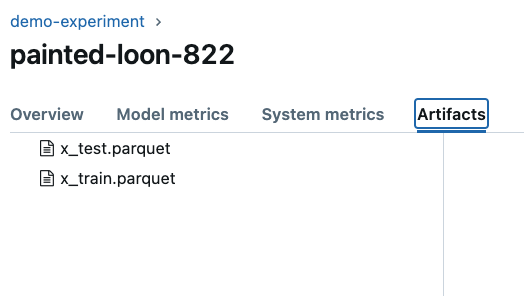

## Images

As part of the model dev process you may end up creating visualizations that can be useful for analysis, or for reporting. You can use mlflow to log the important ones and ignore the rest. After creating the below figure, save into a folder called images, and then you can log whatever is in the `images` folder as an artifact.

array([[<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>]], dtype=object)

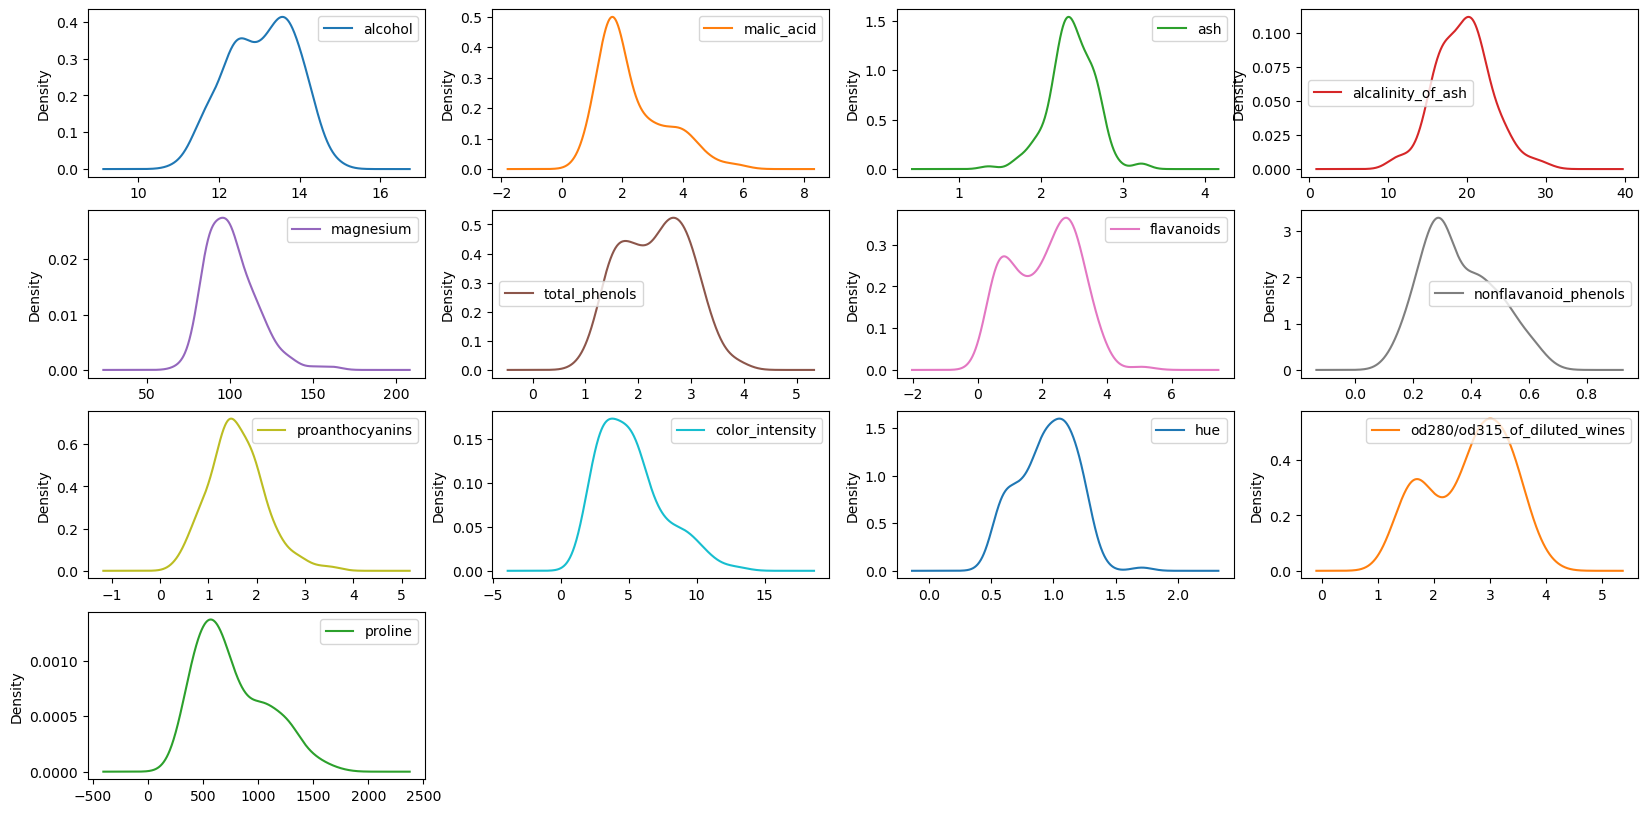

In [25]:
%matplotlib inline
os.makedirs('images', exist_ok = True)
X_train.plot.density(subplots = True, figsize = (20,10), layout = (4,4), sharey = False, sharex = False)

In [26]:
mlflow.log_artifacts('images')
mlflow.end_run()

2025/04/17 21:33:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run aged-panda-598 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1/runs/08e81a2ccea94edda689222ce81825d9.
2025/04/17 21:33:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1.


Notice how all of the artifacts were saved in the same run of the experiment. We could have added an `mlflow.end_run()` in between our `log_artifacts` lines to separate runs if we wanted to.

## Model Management and Model Registry

As you are developing your models you may want to save certain versions of the model, or maybe even all of them, so that you don't have to go back and retrain them later. We can do this in mlflow by logging the models, not as artifacts, but as models, using `log_model`. 

In this section we'll log a couple of models to see how mlflow handles model management. Above, we used `hyperopt` to train a bunch of models at once. Let's do this again, and log some of the models that we train.

### Logging as an Artifact

First we can try logging a model as an artifact. To do this, we must first save the model itself, which we can do by using the `pickle` library. We then log the model as an artifact like we did with data and images. 

In [27]:
import pickle

os.makedirs('../models', exist_ok = True)

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

with open('../models/model.pkl','wb') as f:
    pickle.dump(dt,f)

# First we'll log the model as an artifact
mlflow.log_artifact('../models/model.pkl', artifact_path='my_models')

### Logging as a Model

Logging the model as an artifact only logs the pickle file (the serialized version of the model). It's not really very useful, especially since models contain so much metadata that might be critical to know for deploying the model later. mlflow has a built-in way of logging models specifically, so let's see how to use this, and how it's different from logging models as an artifact.

In [28]:
# Let's do it again, but this time we will log the model using log_model
mlflow.sklearn.log_model(dt, artifact_path = 'better_models')
mlflow.end_run()

2025/04/17 21:33:44 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2025/04/17 21:33:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run stately-doe-783 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1/runs/1c8cb0eb58434daca67c89193d993c1c.
2025/04/17 21:33:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/1.


Ok, so if you go to the mlflow UI at this point you can see the difference in `log_artifact`, which simply logs the pickle file, and `log_model`, which also gives you information about the environment, required packages, and model flavor.

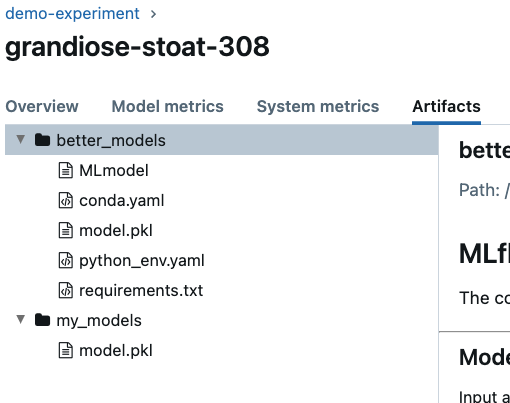

Let's do this one more time, but this time let's use `hyperopt` and log all of the trained models separately. Let's do this in a new experiment called 'demo-experiment2'. 

In [29]:
mlflow.set_experiment('demo-experiment2')
def objective(params):
    with mlflow.start_run():
        classifier_type = params['type']
        del params['type']
        if classifier_type == 'dt':
            clf = DecisionTreeClassifier(**params)
        elif classifier_type == 'rf':
            clf = RandomForestClassifier(**params)        
        else:
            return 0
        acc = cross_val_score(clf, X, y).mean()

        mlflow.set_tag("Model", classifier_type)
        mlflow.log_params(params)
        mlflow.log_metric("accuracy", acc)
        mlflow.sklearn.log_model(clf, artifact_path = 'better_models')
        mlflow.end_run()
        return {'loss': -acc, 'status': STATUS_OK}
search_space = hp.choice('classifier_type', [
    {
        'type': 'dt',
        'criterion': hp.choice('dtree_criterion', ['gini', 'entropy']),
        'max_depth': hp.choice('dtree_max_depth', [None, hp.randint('dtree_max_depth_int', 1,10)]),
        'min_samples_split': hp.randint('dtree_min_samples_split', 2,10)
    },
    {
        'type': 'rf',
        'n_estimators': hp.randint('rf_n_estimators', 20, 500),
        'max_features': hp.randint('rf_max_features', 2,9),
        'criterion': hp.choice('criterion', ['gini', 'entropy'])
    },
])

algo = tpe.suggest
trials = Trials()
best_result = fmin(
        fn=objective, 
        space=search_space,
        algo=algo,
        max_evals=32,
        trials=trials)

2025/04/17 21:33:44 INFO mlflow.tracking.fluent: Experiment with name 'demo-experiment2' does not exist. Creating a new experiment.


  0%|          | 0/32 [00:00<?, ?trial/s, best loss=?]

2025/04/17 21:33:48 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 21:33:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run nebulous-duck-843 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2/runs/830ac32886024ed0989668bc2ef481fe.

2025/04/17 21:33:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2.



  3%|▎         | 1/32 [00:03<01:41,  3.28s/trial, best loss: -0.9103174603174604]

2025/04/17 21:33:51 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 21:33:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run gentle-snipe-604 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2/runs/696f6704a3624b9caadcdbf9f3124927.

2025/04/17 21:33:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2.



  6%|▋         | 2/32 [00:06<01:38,  3.30s/trial, best loss: -0.9103174603174604]

2025/04/17 21:33:55 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 21:33:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run capable-carp-959 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2/runs/b54a381ce0184be1885cbf2e1d13818f.

2025/04/17 21:33:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2.



  9%|▉         | 3/32 [00:10<01:39,  3.43s/trial, best loss: -0.9103174603174604]

2025/04/17 21:33:58 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 21:33:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run crawling-sheep-644 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2/runs/462a68c4bb9a4c9cb6fcedadd00f21a7.

2025/04/17 21:33:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2.



 12%|█▎        | 4/32 [00:13<01:40,  3.57s/trial, best loss: -0.9665079365079364]

2025/04/17 21:34:02 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 21:34:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run auspicious-ram-826 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2/runs/25fc2b0d600648cc9d9717fd3cfde8e0.

2025/04/17 21:34:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2.



 16%|█▌        | 5/32 [00:17<01:34,  3.52s/trial, best loss: -0.9665079365079364]

2025/04/17 21:34:06 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 21:34:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run awesome-stoat-416 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2/runs/a7699b395191481894ac29dc7c77046c.

2025/04/17 21:34:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2.



 19%|█▉        | 6/32 [00:21<01:36,  3.70s/trial, best loss: -0.9777777777777779]

2025/04/17 21:34:09 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 21:34:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run brawny-hawk-515 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2/runs/0022667bf39244d0b43c8405b5ab655e.

2025/04/17 21:34:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2.



 22%|██▏       | 7/32 [00:24<01:29,  3.57s/trial, best loss: -0.9777777777777779]

2025/04/17 21:34:13 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 21:34:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run stately-lamb-20 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2/runs/b730a6d75fd54269841071df8823cf37.

2025/04/17 21:34:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2.



 25%|██▌       | 8/32 [00:28<01:24,  3.52s/trial, best loss: -0.9777777777777779]

2025/04/17 21:34:17 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 21:34:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run glamorous-slug-963 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2/runs/bff933284b5d498e8f2f2a5d0d0ee5d2.

2025/04/17 21:34:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2.



 28%|██▊       | 9/32 [00:32<01:29,  3.88s/trial, best loss: -0.9777777777777779]

2025/04/17 21:34:21 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 21:34:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run agreeable-shark-146 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2/runs/e24b2df6a59d4636a5d09ac4ee52912c.

2025/04/17 21:34:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2.



 31%|███▏      | 10/32 [00:36<01:22,  3.76s/trial, best loss: -0.9777777777777779]

2025/04/17 21:34:32 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 21:34:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run merciful-horse-895 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2/runs/20a63df2926c4ef0898e390fa70b95f0.

2025/04/17 21:34:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2.



 34%|███▍      | 11/32 [00:48<02:13,  6.35s/trial, best loss: -0.9777777777777779]

2025/04/17 21:34:38 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 21:34:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run luminous-turtle-549 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2/runs/5671b2070ff142ef8964112877d1a043.

2025/04/17 21:34:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2.



 38%|███▊      | 12/32 [00:54<02:01,  6.08s/trial, best loss: -0.9777777777777779]

2025/04/17 21:34:42 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 21:34:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run colorful-slug-678 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2/runs/3a13087afce3454fa113a54891a1fc9d.

2025/04/17 21:34:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2.



 41%|████      | 13/32 [00:57<01:42,  5.42s/trial, best loss: -0.9777777777777779]

2025/04/17 21:34:46 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 21:34:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run bouncy-jay-135 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2/runs/f701207fc411442eb95b72bd5da79f1f.

2025/04/17 21:34:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2.



 44%|████▍     | 14/32 [01:01<01:26,  4.83s/trial, best loss: -0.9777777777777779]

2025/04/17 21:34:50 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 21:34:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run vaunted-panda-207 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2/runs/053829319b324c959b737349717b3f35.

2025/04/17 21:34:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2.



 47%|████▋     | 15/32 [01:05<01:20,  4.73s/trial, best loss: -0.9777777777777779]

2025/04/17 21:34:54 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 21:34:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run gifted-midge-942 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2/runs/652319ebe8e2484290a1a57a77740c16.

2025/04/17 21:34:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2.



 50%|█████     | 16/32 [01:09<01:09,  4.35s/trial, best loss: -0.9777777777777779]

2025/04/17 21:34:59 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 21:34:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run bustling-zebra-788 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2/runs/3a7602209e4e4d0daabce5240da68685.

2025/04/17 21:34:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2.



 53%|█████▎    | 17/32 [01:14<01:07,  4.47s/trial, best loss: -0.9777777777777779]

2025/04/17 21:35:02 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 21:35:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run honorable-wren-798 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2/runs/1c7b2bb4469c4a5c9062f548d56f6cdf.

2025/04/17 21:35:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2.



 56%|█████▋    | 18/32 [01:17<00:57,  4.12s/trial, best loss: -0.9777777777777779]

2025/04/17 21:35:05 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 21:35:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run gregarious-koi-370 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2/runs/226527178c94417a89b01186f7bbe61b.

2025/04/17 21:35:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2.



 59%|█████▉    | 19/32 [01:20<00:50,  3.87s/trial, best loss: -0.9777777777777779]

2025/04/17 21:35:10 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 21:35:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run carefree-chimp-982 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2/runs/2d0ee42f65254b96a68e2f0e9adcba03.

2025/04/17 21:35:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2.



 62%|██████▎   | 20/32 [01:25<00:49,  4.14s/trial, best loss: -0.9777777777777779]

2025/04/17 21:35:14 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 21:35:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run abrasive-mouse-748 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2/runs/5f5506b0dab04a75a9dd5e120498ae13.

2025/04/17 21:35:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2.



 66%|██████▌   | 21/32 [01:29<00:43,  3.98s/trial, best loss: -0.9777777777777779]

2025/04/17 21:35:20 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 21:35:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run gaudy-lynx-945 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2/runs/f19a266a5a9845368470cfa9e5e0baa8.

2025/04/17 21:35:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2.



 69%|██████▉   | 22/32 [01:35<00:48,  4.83s/trial, best loss: -0.9777777777777779]

2025/04/17 21:35:25 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 21:35:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run big-dolphin-858 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2/runs/5a0d3dcca7174eb78640a0552d66b860.

2025/04/17 21:35:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2.



 72%|███████▏  | 23/32 [01:40<00:43,  4.79s/trial, best loss: -0.9777777777777779]

2025/04/17 21:35:31 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 21:35:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run persistent-moose-110 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2/runs/8b6d00766ec14a19b63c830a2529a213.

2025/04/17 21:35:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2.



 75%|███████▌  | 24/32 [01:46<00:40,  5.08s/trial, best loss: -0.9777777777777779]

2025/04/17 21:35:35 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 21:35:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run unique-hound-44 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2/runs/56961b543d2d46aa822ed621f7f1b530.

2025/04/17 21:35:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2.



 78%|███████▊  | 25/32 [01:50<00:33,  4.82s/trial, best loss: -0.9777777777777779]

2025/04/17 21:35:40 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 21:35:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run tasteful-koi-930 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2/runs/e0534042917745259347d7676a72f09d.

2025/04/17 21:35:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2.



 81%|████████▏ | 26/32 [01:55<00:29,  4.90s/trial, best loss: -0.9777777777777779]

2025/04/17 21:35:44 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 21:35:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run able-bug-716 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2/runs/4bb5d54b296c46c0b005a5e8223497a6.

2025/04/17 21:35:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2.



 84%|████████▍ | 27/32 [01:59<00:23,  4.74s/trial, best loss: -0.9833333333333332]

2025/04/17 21:35:49 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 21:35:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run painted-ox-470 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2/runs/e78b71b69e9b484691939e347a552124.

2025/04/17 21:35:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2.



 88%|████████▊ | 28/32 [02:04<00:18,  4.63s/trial, best loss: -0.9833333333333332]

2025/04/17 21:35:53 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 21:35:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run gaudy-hawk-639 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2/runs/b4a091d78ee04644a36496d97976b005.

2025/04/17 21:35:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2.



 91%|█████████ | 29/32 [02:08<00:13,  4.41s/trial, best loss: -0.9833333333333332]

2025/04/17 21:35:57 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 21:35:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run gregarious-goat-864 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2/runs/9fb8f2d319d145c89c9c213e67741f0c.

2025/04/17 21:35:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2.



 94%|█████████▍| 30/32 [02:12<00:08,  4.26s/trial, best loss: -0.9833333333333332]

2025/04/17 21:36:01 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 21:36:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run nebulous-sloth-408 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2/runs/4d4c8cd8a681435eb3c989cb8d46435f.

2025/04/17 21:36:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2.



 97%|█████████▋| 31/32 [02:16<00:04,  4.25s/trial, best loss: -0.9833333333333332]

2025/04/17 21:36:06 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.

2025/04/17 21:36:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run clean-jay-900 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2/runs/98b7ed8ce8d94ca684407c1ec7b98104.

2025/04/17 21:36:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/2.



100%|██████████| 32/32 [02:21<00:00,  4.41s/trial, best loss: -0.9833333333333332]


### Loading Models

Now that models have been logged, you can load specific models back into python for predicting and further analysis. There are two main ways to do this. The mlflow UI actually gives you some instructions, with code that you copy and paste.

In [30]:
# .

In [31]:
# logged_model = 'runs:/7ce75c302a9e4602aee4e673c124f127/better_models' #replace with one of your models

# # Load model as a PyFuncModel.
# loaded_model = mlflow.pyfunc.load_model(logged_model)
# loaded_model

In [32]:
# sklearn_model = mlflow.sklearn.load_model(logged_model)
# sklearn_model

In [33]:
# sklearn_model.fit(X_train, y_train)
# preds = sklearn_model.predict(X_test)
# preds[:5]

### Model Registry

Typically, you will **register** your *chosen* model, the model you plan to put into production. But, sometimes, after you've chosen and registered a model, you may need to replace that model with a new version. For example, the model may have gone into production and started to degrade in performance, and so the model needed to be retrained. Or, you go to deploy your model and notice an error or bug, and now have to go back and retrain it.

In this section let's see how we take our logged models and register them in the model registry, which then can get picked up by the production process, or engineer, for deployment. First, I'll demonstrate how this is done within the UI, but then below I'll show how we can use the python API to do the same thing.

In [34]:
# runid = '7ce75c302a9e4602aee4e673c124f127'
# mod_path = f'runs:/{runid}/artifacts/better_models'
# mlflow.register_model(model_uri = mod_path, name = 'wine_model_from_nb')

## Common Issues

- Nothing is appearing in the MLFlow UI: make sure you start the UI from the directory where your notebook is running.  
- I installed a library, but I'm getting an error loading it: be sure you installed it in the same environment as where your notebook is running.  
- MLFlow doesn't seem to be working at all, I'm just getting errors all over the place: this might be a versioning issue.  
- The UI broke, I can't get back to it: `sudo lsof -i :5000 | awk '{print $2}' | tail -n +2 | xargs kill`



# Experiment Tracking and Model Registry Lab

## Overview

In this lab you will each download a new dataset and attempt to train a good model, and use mlflow to keep track of all of your experiments, log your metrics, artifacts and models, and then register a final set of models for "deployment", though we won't actually deploy them anywhere yet.

## Goal

Your goal is **not** to become a master at MLFlow - this is not a course on learning all of the ins and outs of MLFlow. Instead, your goal is to understand when and why it is important to track your model development process (tracking experiments, artifacts and models) and to get into the habit of doing so, and then learn at least the basics of how MLFlow helps you do this so that you can then compare with other tools that are available.

## Data

You can choose your own dataset to use here. It will be helpful to choose a dataset that is already fairly clean and easy to work with. You can even use a dataset that you've used in a previous course. We will do a lot of labs where we do different things with datasets, so if you can find one that is interesting enough for modeling, it should work for most of the rest of the course. 

There are tons of places where you can find open public datasets. Choose something that interests you, but don't overthink it.

[Kaggle Datasets](https://www.kaggle.com/datasets)  
[HuggingFace Datasets](https://huggingface.co/docs/datasets/index)  
[Dagshub Datasets](https://dagshub.com/datasets/)  
[UCI](https://archive.ics.uci.edu/ml/datasets.php)  
[Open Data on AWS](https://registry.opendata.aws/)  
[Yelp](https://www.yelp.com/dataset)  
[MovieLens](https://grouplens.org/datasets/movielens/)  
And so many more...

## Instructions

Once you have selected a set of data, create a brand new experiment in MLFlow and begin exploring your data. Do some EDA, clean up, and learn about your data. You do not need to begin tracking anything yet, but you can if you want to (e.g. you can log different versions of your data as you clean it up and do any feature engineering). Do not spend a ton of time on this part. Your goal isn't really to build a great model, so don't spend hours on feature engineering and missing data imputation and things like that.

Once your data is clean, begin training models and tracking your experiments. If you intend to use this same dataset for your final project, then start thinking about what your model might look like when you actually deploy it. For example, when you engineer new features, be sure to save the code that does this, as you will need this in the future. If your final model has 1000 complex features, you might have a difficult time deploying it later on. If your final model takes 15 minutes to train, or takes a long time to score a new batch of data, you may want to think about training a less complex model.

Now, when tracking your experiments, at a *minimum*, you should:

1. Try at least 3 different ML algorithms (e.g. linear regression, decision tree, random forest, etc.).
2. Do hyperparameter tuning for **each** algorithm.
3. Do some very basic feature selection, and repeat the above steps with these reduced sets of features.
4. Identify the top 3 best models and note these down for later.
6. Choose the **final** "best" model that you would deploy or use on future data, stage it (in MLFlow), and run it on the test set to get a final measure of performance. Don't forget to log the test set metric.
7. Be sure you logged the exact training, validation, and testing datasets for the 3 best models, as well as hyperparameter values, and the values of your metrics.  
8. Push your code to Github. No need to track the mlruns folder, the images folder, any datasets, or the sqlite database in git.

### Turning It In

In the MLFlow UI, next to the refresh button you should see three vertical dots. Click the dots and then download your experiments as a csv file. Open the csv file in Excel and highlight the rows for your top 3 models from step 4, highlight the run where you applied your best model to the test set, and then save as an excel file. Take a snapshot of the Models page in the MLFLow UI showing the model you staged in step 6 above. Submit the excel file and the snapshot to Canvas.

Best 3 models are rf_selected_top_3, random_forest_feature_selection and xgboost_feature_selection

In [35]:
experiment_name = "movie_rating_prediction"
try:
    experiment_id = mlflow.create_experiment(experiment_name)
    print(f"Created new experiment: {experiment_name} with ID: {experiment_id}")
except:
    experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
    print(f"Using existing experiment: {experiment_name} with ID: {experiment_id}")

mlflow.set_experiment(experiment_name)

Created new experiment: movie_rating_prediction with ID: 3


<Experiment: artifact_location='mlflow-artifacts:/3', creation_time=1744950966337, experiment_id='3', last_update_time=1744950966337, lifecycle_stage='active', name='movie_rating_prediction', tags={}>

In [36]:
df_netflix = pd.read_csv('../data/movies.csv')

df_netflix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8560 entries, 0 to 8559
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            8560 non-null   int64  
 1   title         8560 non-null   object 
 2   overview      8560 non-null   object 
 3   release_date  8558 non-null   object 
 4   popularity    8560 non-null   float64
 5   vote_average  8560 non-null   float64
 6   vote_count    8560 non-null   int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 468.3+ KB


In [37]:
df_netflix.columns

Index(['id', 'title', 'overview', 'release_date', 'popularity', 'vote_average',
       'vote_count'],
      dtype='object')

In [38]:
df_netflix

,id,title,overview,release_date,popularity,vote_average,vote_count
0,278,The Shawshank Redemption,Imprisoned in the 1940s for the double murder ...,1994-09-23,5.522,8.708,27883
1,238,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...",1972-03-14,5.317,8.689,21151
2,240,The Godfather Part II,In the continuing saga of the Corleone crime f...,1974-12-20,4.747,8.570,12771
3,424,Schindler's List,The true story of how businessman Oskar Schind...,1993-12-15,4.457,8.567,16219
4,1356039,Counterattack,When a hostage rescue mission creates a new en...,2025-02-27,9.430,8.524,431
...,...,...,...,...,...,...,...
8555,291264,The Family Fang,A brother and sister return to their family ho...,2016-04-16,3.535,5.800,329
8556,250349,Barbecue,"On his 50th birthday, a man who's been watchin...",2014-04-30,3.829,5.834,699
8557,150202,The Haunting in Connecticut 2: Ghosts of Georgia,A young family moves into a historic home in G...,2013-02-01,3.533,5.800,520
8558,4942,Leatherheads,A light hearted comedy about the beginnings of...,2008-03-24,3.532,5.800,457


In [39]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import mlflow

df_train, df_test = train_test_split(df_netflix, test_size=0.2, random_state=42)

features = ['popularity', 'vote_count'] 
X_train = df_train[features]
y_train = df_train['vote_average']
X_test = df_test[features]
y_test = df_test['vote_average']

with mlflow.start_run():
    X_train_train, X_val, y_train_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )
    
    model = LinearRegression()
    model.fit(X_train_train, y_train_train)
    
    y_pred_val = model.predict(X_val)
    
    rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
    
    mlflow.log_param("model", "LinearRegression")
    mlflow.log_metric("rmse", rmse)
    
    mlflow.sklearn.log_model(model, "model")
    
    print(f"RMSE: {rmse:.4f}")

2025/04/17 21:36:09 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2025/04/17 21:36:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run overjoyed-newt-365 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/3/runs/e754df272378460bbe0f0d8a06df20ad.
2025/04/17 21:36:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/3.


RMSE: 0.5744


# Feature selection



In [40]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import mlflow
import os

if not os.path.exists("models"):
    os.makedirs("models")

df_train, df_test = train_test_split(df_netflix, test_size=0.2, random_state=42)

features = ['popularity', 'vote_count'] 
X_train = df_train[features]
y_train = df_train['vote_average']
X_test = df_test[features]
y_test = df_test['vote_average']

with mlflow.start_run():
    X_train_train, X_val, y_train_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )
    
    model = LinearRegression()
    model.fit(X_train_train, y_train_train)
    
    y_pred_val = model.predict(X_val)
    
    rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
    
    mlflow.log_param("model", "LinearRegression")
    mlflow.log_metric("rmse", rmse)
    
    mlflow.sklearn.log_model(model, "model")
    
    import joblib
    joblib.dump(model, "models/linear_regression_model.pkl")
    
    print(f"RMSE: {rmse:.4f}")
    print(f"Model saved to: models/linear_regression_model.pkl")

2025/04/17 21:36:12 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2025/04/17 21:36:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run redolent-goose-683 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/3/runs/64d7503f2e594afaa5fdb30292a78898.
2025/04/17 21:36:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/3.


RMSE: 0.5744
Model saved to: models/linear_regression_model.pkl


# Decision Tree

In [41]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder

if not os.path.exists("models"):
    os.makedirs("models")

df_netflix = pd.read_csv('../data/movies.csv')
selected_features = ['title', 'release_date', 'popularity', 'vote_count']
target = 'vote_average'

df_feat = df_netflix[selected_features + [target]].copy()

def preprocess_data(df):
    df_processed = df.copy()
    
    label_encoders = {}
    for column in ['title']:
        le = LabelEncoder()
        df_processed[column] = le.fit_transform(df_processed[column])
        label_encoders[column] = le
    
    df_processed['release_year'] = pd.to_datetime(df_processed['release_date'], errors='coerce').dt.year
    df_processed.drop('release_date', axis=1, inplace=True)
    
    return df_processed, label_encoders

df_processed, label_encoders = preprocess_data(df_feat)
X = df_processed.drop(target, axis=1)
y = df_processed[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [42]:
def train_decision_tree_with_tuning(X_train, y_train, X_val, y_val):
    param_grid = {
        'max_depth': [3, 5, 7, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    dt = DecisionTreeRegressor(random_state=42)
    
    grid_search = GridSearchCV(
        estimator=dt,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        return_train_score=True,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    cv_results = pd.DataFrame(grid_search.cv_results_)
    cv_results['rmse'] = np.sqrt(-cv_results['mean_test_score'])
    cv_results = cv_results.sort_values('rmse')
    
    best_dt = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    y_train_pred = best_dt.predict(X_train)
    y_val_pred = best_dt.predict(X_val)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
    return best_dt, best_params, train_rmse, val_rmse, cv_results

with mlflow.start_run(run_name="decision_tree_tuning"):
    best_dt, best_params, train_rmse, val_rmse, cv_results = train_decision_tree_with_tuning(
        X_train_train, y_train_train, X_val, y_val
    )
    
    mlflow.log_param("model_type", "DecisionTreeRegressor")
    for param, value in best_params.items():
        mlflow.log_param(param, value)
    
    mlflow.log_param("features", list(X_train.columns))
    mlflow.log_metric("train_rmse", train_rmse)
    mlflow.log_metric("val_rmse", val_rmse)
    
    mlflow.sklearn.log_model(best_dt, "decision_tree_model")
    joblib.dump(best_dt, "models/decision_tree_best.pkl")
    
    top_models = cv_results.head(3)
    for i, (idx, row) in enumerate(top_models.iterrows()):
        params = {
            'max_depth': row['param_max_depth'],
            'min_samples_split': row['param_min_samples_split'],
            'min_samples_leaf': row['param_min_samples_leaf'],
            'random_state': 42
        }
        
        model = DecisionTreeRegressor(**params)
        model.fit(X_train_train, y_train_train)
        
        model_name = f"dt_top_{i+1}"
        model_path = f"models/{model_name}.pkl"
        joblib.dump(model, model_path)
        
        with mlflow.start_run(nested=True, run_name=model_name):
            for param_name, param_value in params.items():
                mlflow.log_param(param_name, param_value)
            
            y_train_pred = model.predict(X_train_train)
            y_val_pred = model.predict(X_val)
            
            train_rmse = np.sqrt(mean_squared_error(y_train_train, y_train_pred))
            val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
            
            mlflow.log_metric("train_rmse", train_rmse)
            mlflow.log_metric("val_rmse", val_rmse)
            mlflow.sklearn.log_model(model, model_name)
    
    print(f"Best parameters: {best_params}")
    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Validation RMSE: {val_rmse:.4f}")
    print(f"Model saved to: models/decision_tree_best.pkl")

Fitting 5 folds for each of 45 candidates, totalling 225 fits


2025/04/17 21:36:18 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2025/04/17 21:36:22 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2025/04/17 21:36:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run dt_top_1 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/3/runs/4d17fe12ea5b4cc4bd8e5fb9388b581b.
2025/04/17 21:36:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/3.
2025/04/17 21:36:27 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2025/04/17 21:36:28 INFO mlflow.tracking._tracking_service.client: 🏃 View run dt_top_2 at: https://mlflow-server1-759416646959.us-we

Best parameters: {'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 2}
Training RMSE: 0.5153
Validation RMSE: 0.5414
Model saved to: models/decision_tree_best.pkl


In [43]:
def select_important_features(model, X, threshold=0.1):
    importances = model.feature_importances_
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    selected = feature_importance[feature_importance['importance'] > threshold]['feature'].tolist()
    
    return selected, feature_importance

with mlflow.start_run(run_name="decision_tree_feature_selection"):
    important_features, importance_df = select_important_features(best_dt, X_train)
    
    print(f"Selected features: {important_features}")
    print("Feature importance:")
    print(importance_df)
    
    X_train_selected = X_train[important_features]
    X_val_selected = X_val[important_features]
    X_test_selected = X_test[important_features]
    
    mlflow.log_param("feature_selection_threshold", 0.1)
    mlflow.log_param("selected_features", important_features)
    for feature, importance in zip(importance_df['feature'], importance_df['importance']):
        mlflow.log_metric(f"importance_{feature}", importance)
    
    param_grid = {
        'max_depth': [3, 5, 7, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    dt_selected = DecisionTreeRegressor(random_state=42)
    
    grid_search_selected = GridSearchCV(
        estimator=dt_selected,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        return_train_score=True,
        verbose=1
    )
    
    grid_search_selected.fit(X_train_selected, y_train)
    
    cv_results_selected = pd.DataFrame(grid_search_selected.cv_results_)
    cv_results_selected['rmse'] = np.sqrt(-cv_results_selected['mean_test_score'])
    cv_results_selected = cv_results_selected.sort_values('rmse')
    
    best_dt_selected = grid_search_selected.best_estimator_
    best_params_selected = grid_search_selected.best_params_
    
    y_train_pred = best_dt_selected.predict(X_train_selected)
    y_val_pred = best_dt_selected.predict(X_val_selected)
    y_test_pred = best_dt_selected.predict(X_test_selected)
    
    train_rmse_selected = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse_selected = np.sqrt(mean_squared_error(y_val, y_val_pred))
    test_rmse_selected = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    mlflow.log_param("model_type", "DecisionTreeRegressor_FeatureSelection")
    for param, value in best_params_selected.items():
        mlflow.log_param(param, value)
    
    mlflow.log_metric("train_rmse", train_rmse_selected)
    mlflow.log_metric("val_rmse", val_rmse_selected)
    mlflow.log_metric("test_rmse", test_rmse_selected)
    
    model_path = "models/decision_tree_selected_features.pkl"
    joblib.dump(best_dt_selected, model_path)
    mlflow.log_artifact(model_path)
    mlflow.sklearn.log_model(best_dt_selected, "decision_tree_selected_features")
    
    top_models_selected = cv_results_selected.head(3)
    for i, (idx, row) in enumerate(top_models_selected.iterrows()):
        params = {
            'max_depth': row['param_max_depth'],
            'min_samples_split': row['param_min_samples_split'],
            'min_samples_leaf': row['param_min_samples_leaf'],
            'random_state': 42
        }
        
        model = DecisionTreeRegressor(**params)
        model.fit(X_train_selected, y_train)
        
        model_name = f"dt_selected_top_{i+1}"
        model_path = f"models/{model_name}.pkl"
        joblib.dump(model, model_path)
        
        with mlflow.start_run(nested=True, run_name=model_name):
            for param_name, param_value in params.items():
                mlflow.log_param(param_name, param_value)
            
            y_train_pred = model.predict(X_train_selected)
            y_val_pred = model.predict(X_val_selected)
            
            train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
            val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
            
            mlflow.log_metric("train_rmse", train_rmse)
            mlflow.log_metric("val_rmse", val_rmse)
            mlflow.sklearn.log_model(model, model_name)
    

Selected features: ['vote_count', 'release_year', 'popularity']
Feature importance:
        feature  importance
2    vote_count    0.422721
3  release_year    0.376741
1    popularity    0.165047
0         title    0.035491
Fitting 5 folds for each of 45 candidates, totalling 225 fits


2025/04/17 21:36:36 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2025/04/17 21:36:39 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2025/04/17 21:36:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run dt_selected_top_1 at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/3/runs/c3fee796ed64425dabca821910cc4fc0.
2025/04/17 21:36:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://mlflow-server1-759416646959.us-west2.run.app/#/experiments/3.
2025/04/17 21:36:43 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2025/04/17 21:36:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run dt_selected_top_2 at: https://mlflow-server1-

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
def train_random_forest_with_tuning(X_train, y_train, X_val, y_val):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    rf = RandomForestRegressor(random_state=42)
    
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        return_train_score=True,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    cv_results = pd.DataFrame(grid_search.cv_results_)
    cv_results['rmse'] = np.sqrt(-cv_results['mean_test_score'])
    cv_results = cv_results.sort_values('rmse')
    
    best_rf = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    y_train_pred = best_rf.predict(X_train)
    y_val_pred = best_rf.predict(X_val)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
    return best_rf, best_params, train_rmse, val_rmse, cv_results

with mlflow.start_run(run_name="random_forest_tuning"):
    best_rf, best_params, train_rmse, val_rmse, cv_results = train_random_forest_with_tuning(
        X_train_train, y_train_train, X_val, y_val
    )
    
    mlflow.log_param("model_type", "RandomForestRegressor")
    for param, value in best_params.items():
        mlflow.log_param(param, value)
    
    mlflow.log_param("features", list(X_train.columns))
    mlflow.log_metric("train_rmse", train_rmse)
    mlflow.log_metric("val_rmse", val_rmse)
    
    mlflow.sklearn.log_model(best_rf, "random_forest_model")
    joblib.dump(best_rf, "models/random_forest_best.pkl")
    
    top_models = cv_results.head(3)
    for i, (idx, row) in enumerate(top_models.iterrows()):
        params = {
            'n_estimators': row['param_n_estimators'],
            'max_depth': row['param_max_depth'],
            'min_samples_split': row['param_min_samples_split'],
            'min_samples_leaf': row['param_min_samples_leaf'],
            'random_state': 42
        }
        
        model = RandomForestRegressor(**params)
        model.fit(X_train_train, y_train_train)
        
        model_name = f"rf_top_{i+1}"
        model_path = f"models/{model_name}.pkl"
        joblib.dump(model, model_path)
        
        with mlflow.start_run(nested=True, run_name=model_name):
            for param_name, param_value in params.items():
                mlflow.log_param(param_name, param_value)
            
            y_train_pred = model.predict(X_train_train)
            y_val_pred = model.predict(X_val)
            
            train_rmse = np.sqrt(mean_squared_error(y_train_train, y_train_pred))
            val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
            
            mlflow.log_metric("train_rmse", train_rmse)
            mlflow.log_metric("val_rmse", val_rmse)
            mlflow.sklearn.log_model(model, model_name)
    
    print(f"Best parameters: {best_params}")
    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Validation RMSE: {val_rmse:.4f}")
    print(f"Model saved to: models/random_forest_best.pkl")

Fitting 5 folds for each of 81 candidates, totalling 405 fits


2025/04/17 21:30:34 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2025/04/17 21:30:41 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2025/04/17 21:30:44 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2025/04/17 21:30:50 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Best parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Training RMSE: 0.4723
Validation RMSE: 0.5329
Model saved to: models/random_forest_best.pkl


In [ ]:
def select_important_features_rf(model, X, threshold=0.05):
    importances = model.feature_importances_
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    selected = feature_importance[feature_importance['importance'] > threshold]['feature'].tolist()
    
    return selected, feature_importance

with mlflow.start_run(run_name="random_forest_feature_selection"):
    important_features, importance_df = select_important_features_rf(best_rf, X_train)
    
    print(f"Selected features: {important_features}")
    print("Feature importance:")
    print(importance_df)
    
    X_train_selected = X_train[important_features]
    X_val_selected = X_val[important_features]
    X_test_selected = X_test[important_features]
    
    mlflow.log_param("feature_selection_threshold", 0.05)
    mlflow.log_param("selected_features", important_features)
    for feature, importance in zip(importance_df['feature'], importance_df['importance']):
        mlflow.log_metric(f"importance_{feature}", importance)
    
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    rf_selected = RandomForestRegressor(random_state=42)
    
    grid_search_selected = GridSearchCV(
        estimator=rf_selected,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        return_train_score=True,
        verbose=1
    )
    
    grid_search_selected.fit(X_train_selected, y_train)
    cv_results_selected = pd.DataFrame(grid_search_selected.cv_results_)
    cv_results_selected['rmse'] = np.sqrt(-cv_results_selected['mean_test_score'])
    cv_results_selected = cv_results_selected.sort_values('rmse')
    
    best_rf_selected = grid_search_selected.best_estimator_
    best_params_selected = grid_search_selected.best_params_
    
    y_train_pred = best_rf_selected.predict(X_train_selected)
    y_val_pred = best_rf_selected.predict(X_val_selected)
    y_test_pred = best_rf_selected.predict(X_test_selected)
    
    train_rmse_selected = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse_selected = np.sqrt(mean_squared_error(y_val, y_val_pred))
    test_rmse_selected = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    mlflow.log_param("model_type", "RandomForestRegressor_FeatureSelection")
    for param, value in best_params_selected.items():
        mlflow.log_param(param, value)
    
    mlflow.log_metric("train_rmse", train_rmse_selected)
    mlflow.log_metric("val_rmse", val_rmse_selected)
    mlflow.log_metric("test_rmse", test_rmse_selected)
    
    model_path = "models/random_forest_selected_features.pkl"
    joblib.dump(best_rf_selected, model_path)
    mlflow.log_artifact(model_path)
    mlflow.sklearn.log_model(best_rf_selected, "random_forest_selected_features")
    
    top_models_selected = cv_results_selected.head(3)
    for i, (idx, row) in enumerate(top_models_selected.iterrows()):
        params = {
            'n_estimators': row['param_n_estimators'],
            'max_depth': row['param_max_depth'],
            'min_samples_split': row['param_min_samples_split'],
            'min_samples_leaf': row['param_min_samples_leaf'],
            'random_state': 42
        }
        
        model = RandomForestRegressor(**params)
        model.fit(X_train_selected, y_train)
        
        model_name = f"rf_selected_top_{i+1}"
        model_path = f"models/{model_name}.pkl"
        joblib.dump(model, model_path)
        
        with mlflow.start_run(nested=True, run_name=model_name):
            for param_name, param_value in params.items():
                mlflow.log_param(param_name, param_value)
            
            y_train_pred = model.predict(X_train_selected)
            y_val_pred = model.predict(X_val_selected)
            
            train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
            val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
            
            mlflow.log_metric("train_rmse", train_rmse)
            mlflow.log_metric("val_rmse", val_rmse)
            mlflow.sklearn.log_model(model, model_name)

Selected features: ['vote_count', 'release_year', 'popularity', 'title']
Feature importance:
        feature  importance
2    vote_count    0.370821
3  release_year    0.330965
1    popularity    0.155534
0         title    0.142679
Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [ ]:
import xgboost as xgb

from xgboost import XGBRegressor

def train_xgboost_with_tuning(X_train, y_train, X_val, y_val):
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
    
    xgb_model = XGBRegressor(random_state=42, objective='reg:squarederror')
    
    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        return_train_score=True,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    cv_results = pd.DataFrame(grid_search.cv_results_)
    cv_results['rmse'] = np.sqrt(-cv_results['mean_test_score'])
    cv_results = cv_results.sort_values('rmse')
    
    best_xgb = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    y_train_pred = best_xgb.predict(X_train)
    y_val_pred = best_xgb.predict(X_val)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    
    return best_xgb, best_params, train_rmse, val_rmse, cv_results

with mlflow.start_run(run_name="xgboost_tuning"):
    best_xgb, best_params, train_rmse, val_rmse, cv_results = train_xgboost_with_tuning(
        X_train_train, y_train_train, X_val, y_val
    )
    
    mlflow.log_param("model_type", "XGBRegressor")
    for param, value in best_params.items():
        mlflow.log_param(param, value)
    
    mlflow.log_param("features", list(X_train.columns))
    mlflow.log_metric("train_rmse", train_rmse)
    mlflow.log_metric("val_rmse", val_rmse)
    
    mlflow.sklearn.log_model(best_xgb, "xgboost_model")
    joblib.dump(best_xgb, "models/xgboost_best.pkl")
    
    top_models = cv_results.head(3)
    for i, (idx, row) in enumerate(top_models.iterrows()):
        params = {
            'n_estimators': row['param_n_estimators'],
            'learning_rate': row['param_learning_rate'],
            'max_depth': row['param_max_depth'],
            'min_child_weight': row['param_min_child_weight'],
            'subsample': row['param_subsample'],
            'colsample_bytree': row['param_colsample_bytree'],
            'random_state': 42,
            'objective': 'reg:squarederror'
        }
        
        model = XGBRegressor(**params)
        model.fit(X_train_train, y_train_train)
        
        model_name = f"xgb_top_{i+1}"
        model_path = f"models/{model_name}.pkl"
        joblib.dump(model, model_path)
        
        with mlflow.start_run(nested=True, run_name=model_name):
            for param_name, param_value in params.items():
                mlflow.log_param(param_name, param_value)
            
            y_train_pred = model.predict(X_train_train)
            y_val_pred = model.predict(X_val)
            
            train_rmse = np.sqrt(mean_squared_error(y_train_train, y_train_pred))
            val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
            
            mlflow.log_metric("train_rmse", train_rmse)
            mlflow.log_metric("val_rmse", val_rmse)
            mlflow.sklearn.log_model(model, model_name)
    
    print(f"Best parameters: {best_params}")
    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Validation RMSE: {val_rmse:.4f}")
    print(f"Model saved to: models/xgboost_best.pkl")
    
    with mlflow.start_run(nested=True, run_name="xgboost_feature_selection"):
        feature_importance = best_xgb.feature_importances_
        importance_df = pd.DataFrame({
            'feature': X_train.columns,
            'importance': feature_importance
        }).sort_values('importance', ascending=False)
        
        threshold = 0.05
        important_features = importance_df[importance_df['importance'] > threshold]['feature'].tolist()
        
        for feature, importance in zip(importance_df['feature'], importance_df['importance']):
            mlflow.log_metric(f"importance_{feature}", importance)
        
        print(f"Selected features: {important_features}")
        
        X_train_selected = X_train[important_features]
        X_val_selected = X_val[important_features]
        X_test_selected = X_test[important_features]
        
        param_grid = {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5],
            'min_child_weight': [1, 3],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        }
        
        xgb_selected = XGBRegressor(random_state=42, objective='reg:squarederror')
        
        grid_search_selected = GridSearchCV(
            estimator=xgb_selected,
            param_grid=param_grid,
            cv=5,
            scoring='neg_mean_squared_error',
            n_jobs=-1,
            return_train_score=True,
            verbose=1
        )
        
        grid_search_selected.fit(X_train_selected, y_train)
        
        cv_results_selected = pd.DataFrame(grid_search_selected.cv_results_)
        cv_results_selected['rmse'] = np.sqrt(-cv_results_selected['mean_test_score'])
        cv_results_selected = cv_results_selected.sort_values('rmse')
        
        best_xgb_selected = grid_search_selected.best_estimator_
        best_params_selected = grid_search_selected.best_params_
        
        y_train_pred = best_xgb_selected.predict(X_train_selected)
        y_val_pred = best_xgb_selected.predict(X_val_selected)
        y_test_pred = best_xgb_selected.predict(X_test_selected)
        
        train_rmse_selected = np.sqrt(mean_squared_error(y_train, y_train_pred))
        val_rmse_selected = np.sqrt(mean_squared_error(y_val, y_val_pred))
        test_rmse_selected = np.sqrt(mean_squared_error(y_test, y_test_pred))
        
        mlflow.log_param("model_type", "XGBRegressor_FeatureSelection")
        for param, value in best_params_selected.items():
            mlflow.log_param(param, value)
        
        mlflow.log_param("features", important_features)
        mlflow.log_param("feature_selection_threshold", threshold)
        mlflow.log_metric("train_rmse", train_rmse_selected)
        mlflow.log_metric("val_rmse", val_rmse_selected)
        mlflow.log_metric("test_rmse", test_rmse_selected)
        
        model_path = "models/xgboost_selected_features.pkl"
        joblib.dump(best_xgb_selected, model_path)
        mlflow.sklearn.log_model(best_xgb_selected, "xgboost_selected_features")
        
        top_models_selected = cv_results_selected.head(3)
        for i, (idx, row) in enumerate(top_models_selected.iterrows()):
            params = {
                'n_estimators': row['param_n_estimators'],
                'learning_rate': row['param_learning_rate'],
                'max_depth': row['param_max_depth'],
                'min_child_weight': row['param_min_child_weight'],
                'subsample': row['param_subsample'],
                'colsample_bytree': row['param_colsample_bytree'],
                'random_state': 42,
                'objective': 'reg:squarederror'
            }
            
            model = XGBRegressor(**params)
            model.fit(X_train_selected, y_train)
            
            model_name = f"xgb_selected_top_{i+1}"
            model_path = f"models/{model_name}.pkl"
            joblib.dump(model, model_path)
            
            with mlflow.start_run(nested=True, run_name=model_name):
                for param_name, param_value in params.items():
                    mlflow.log_param(param_name, param_value)
                
                y_train_pred = model.predict(X_train_selected)
                y_val_pred = model.predict(X_val_selected)
                
                train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
                val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
                
                mlflow.log_metric("train_rmse", train_rmse)
                mlflow.log_metric("val_rmse", val_rmse)
                mlflow.sklearn.log_model(model, model_name)
        
        print(f"Best parameters with selected features: {best_params_selected}")
        print(f"Training RMSE with selected features: {train_rmse_selected:.4f}")
        print(f"Validation RMSE with selected features: {val_rmse_selected:.4f}")
        print(f"Test RMSE with selected features: {test_rmse_selected:.4f}")
        print(f"Model saved to: {model_path}")

# Best 3 models are rf_selected_top_3, random_forest_feature_selection and xgboost_feature_selection

In [ ]:
import mlflow
from mlflow.tracking import MlflowClient
import numpy as np
from sklearn.metrics import mean_squared_error

client = MlflowClient()
best_model_run_id = "6e929804496046298e184fe61dd50c79"
model_uri = f"runs:/{best_model_run_id}/rf_selected_top_3"

registered_model = mlflow.register_model(
    model_uri=model_uri,
    name="MovieRatingPredictor"
)

client.transition_model_version_stage(
    name="MovieRatingPredictor",
    version=registered_model.version,
    stage="Staging"
)

best_model = mlflow.sklearn.load_model(model_uri)

parent_run_id = "6e929804496046298e184fe61dd50c79"  

parent_run = client.get_run(parent_run_id)
if "features" in parent_run.data.params:
    feature_names = eval(parent_run.data.params["features"])
elif hasattr(best_model, 'feature_names_in_'):
    feature_names = best_model.feature_names_in_.tolist()
else:
    feature_names = X_test.columns.tolist()

X_test_for_model = X_test[feature_names].copy() if feature_names else X_test

y_test_pred = best_model.predict(X_test_for_model)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

with mlflow.start_run(run_id=best_model_run_id):
    mlflow.log_metric("test_rmse", test_rmse)

print(f"Model registered as 'MovieRatingPredictor' version {registered_model.version} and staged to 'Staging'")
print(f"Test RMSE: {test_rmse:.4f}")

In [ ]:
top_model_run_ids = [
    "6e929804496046298e184fe61dd50c79",
    "87591dc44865488d84689f0e723d5f19",
    "702ae8f0968f4c30ad189d3212ad1af6"
]

for run_id in top_model_run_ids:
    with mlflow.start_run(run_id=run_id, nested=True):
        mlflow.log_param("train_dataset_shape", str(X_train.shape))
        mlflow.log_param("val_dataset_shape", str(X_val.shape))
        mlflow.log_param("test_dataset_shape", str(X_test.shape))
        
        mlflow.log_param("train_features", str(list(X_train.columns)))
        if 'selected' in run_id or 'feature_selection' in run_id:
            mlflow.log_param("selected_features", str(list(X_train_selected.columns)))
        
        mlflow.log_param("X_train_min", str(X_train.min().to_dict()))
        mlflow.log_param("X_train_max", str(X_train.max().to_dict()))
        mlflow.log_param("X_train_mean", str(X_train.mean().to_dict()))
        
        mlflow.log_param("y_train_min", float(y_train.min()))
        mlflow.log_param("y_train_max", float(y_train.max()))
        mlflow.log_param("y_train_mean", float(y_train.mean()))
        
        print(f"Logged dataset information for run {run_id}")